# Multi-armed Bandits

### Exercise 2.5
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for non-stationary problems. Prepare plots for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter.

In [1]:
using Random
using Plots

First, we automate the experiment process with a function. $\alpha$ dictates the action-value method, and it is what we will focus on for this experiment. 

We assume `bandit` is a function which takes an integer and produces a pair `(reward, optimal_reward)`.

In [2]:
function ϵ_greedy_k_armed_bandit(ϵ::Float64, k::Int, α::Function, bandit::Function, steps::Int)::Dict
    
    total_rewards = 0  
    optimal_rewards = 0
    avg_reward_timeline = []
    avg_optimal_reward_timeline = []
    
    Q = zeros(k)        # estimated action values
    N = zeros(Int, k)   # action counts
    
                        # α is the step-size parameter 
                        # bandit is a function takes an action and returns a corresponding reward
                        # steps is number of steps
    
    for step in 1:steps
        
        if rand() > ϵ
            action = findmax(Q)[2]    # greedy action, argmax
        else
            action = rand(1:k)        # exploration action
        end
        
        (reward, optimal_reward) = bandit(action)
        
        total_rewards += reward
        optimal_rewards += optimal_reward
        N[action] += 1
        Q[action] = Q[action] + α(N[action]) * (reward - Q[action])    # update value estimates
        push!(avg_reward_timeline, total_rewards/step)
        push!(avg_optimal_reward_timeline, optimal_rewards/step)
    end
    
    return Dict("Q" => Q, 
                "N" => N, 
                "total_rewards" => total_rewards, 
                "optimal_rewards" => optimal_rewards,
                "avg_reward_timeline" => avg_reward_timeline, 
                "avg_optimal_reward_timeline" => avg_optimal_reward_timeline)    # return action values
end

ϵ_greedy_k_armed_bandit (generic function with 1 method)

First we will test the water by on a stationary 4-armed bandit problem. The agent will use the sample average action-value method with a 1% exploration rate. We expect the algorithm to perform reasonably well.

In [3]:
Random.seed!(1)

ϵ = 0.01                                        # ϵ exploration rate
α₁ = n -> 1/n                                   # sample average step-size parameter 
steps = 20000
k = 10

stationary_mean_rewards = 10 .* rand(k)

function stationary_bandit(action)
    step_rewards = stationary_mean_rewards + 2 * randn(length(stationary_mean_rewards))
    reward = step_rewards[action]
    optimal_reward = findmax(step_rewards)[1]
    return (reward, optimal_reward)
end

result₁ = ϵ_greedy_k_armed_bandit(ϵ, k, α₁, stationary_bandit, steps)

println(k, "-armed bandit, non-stationary reward problem.")
println("Using sample-average step size parameter.")
println("Performing ", 1000, " steps of the ", ϵ, "-greedy algorithm...\n")
println("Mean action-values:      ", stationary_mean_rewards)
println("Estimated action-values: ", result₁["Q"])
println("Error in estimations:    ", result₁["Q"] - stationary_mean_rewards)
println("Actions taken: ", result₁["N"])
println("Total rewards:   ", result₁["total_rewards"])
println("Optimal rewards: ", result₁["optimal_rewards"])
println("Error: ", result₁["total_rewards"] - result₁["optimal_rewards"])

10-armed bandit, non-stationary reward problem.
Using sample-average step size parameter.
Performing 1000 steps of the 0.01-greedy algorithm...

Mean action-values:      [2.3603334566204692, 3.4651701419196046, 3.127069683360675, 0.0790928339056074, 4.886128300795011, 2.1096820215853596, 9.519163398357339, 9.999046588986136, 2.5166218303197185, 9.866663668987997]
Estimated action-values: [2.482274754192377, 3.3391136509801287, 3.640214261520892, 0.1453441057274286, 5.727004046811232, 2.3008874985274623, 9.859907330242272, 9.972608046911153, 2.5266991947115596, 9.725439368517089]
Error in estimations:    [0.12194129757190764, -0.1260564909394759, 0.5131445781602171, 0.0662512718218212, 0.8408757460162208, 0.19120547694210277, 0.34074393188493346, -0.026438542074982863, 0.010077364391841037, -0.14122430047090795]
Actions taken: [77, 18, 12, 30, 24, 19, 35, 19268, 9, 508]
Total rewards:   197941.01915209892
Optimal rewards: 229754.2254120302
Error: -31813.206259931292


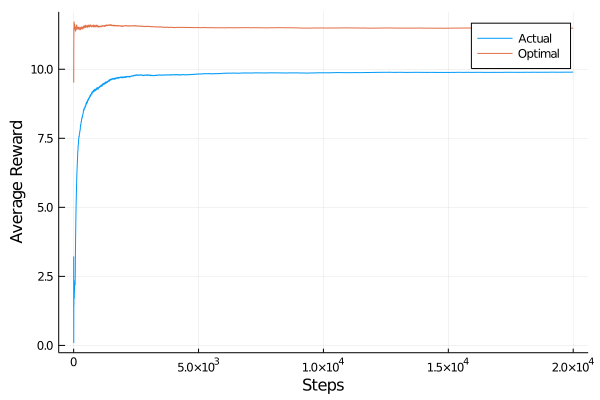

In [4]:
plot(1:steps, result₁["avg_reward_timeline"], label="Actual")
plot!(1:steps, result₁["avg_optimal_reward_timeline"], label="Optimal")
ylabel!("Average Reward")
xlabel!("Steps")

Note that the average reward will converge over time.

Now we use the same method on a nonstationary 4-armed bandit problem. The rewards start from the same as before, but follow a random walk as they are given out. The premise of the exercise suggests that the agent will perform poorly.

In [5]:
Random.seed!(42)

moving_mean_rewards = copy(stationary_mean_rewards)

function moving_bandit(action)
    for i in 1:length(moving_mean_rewards)
        moving_mean_rewards[i] += 0.1 * randn()
    end
    reward = moving_mean_rewards[action]
    optimal_reward = findmax(moving_mean_rewards)[1]
    return (reward, optimal_reward)
end

result₂ = ϵ_greedy_k_armed_bandit(ϵ, k, α₁, moving_bandit, steps)

println(k, "-armed bandit, moving reward problem.")
println("Using sample-average step size parameter.")
println("Performing ", steps, " steps of the ", ϵ, "-greedy algorithm...\n")
println("Actions taken: ", result₂["N"])
println("Total rewards:   ", result₂["total_rewards"])
println("Optimal rewards: ", result₂["optimal_rewards"])
println("Error: ", result₂["total_rewards"] - result₂["optimal_rewards"])

10-armed bandit, moving reward problem.
Using sample-average step size parameter.
Performing 20000 steps of the 0.01-greedy algorithm...

Actions taken: [258, 21, 21, 20, 14, 22, 9732, 785, 16, 9111]
Total rewards:   337988.42413946544
Optimal rewards: 403820.4371486234
Error: -65832.01300915796


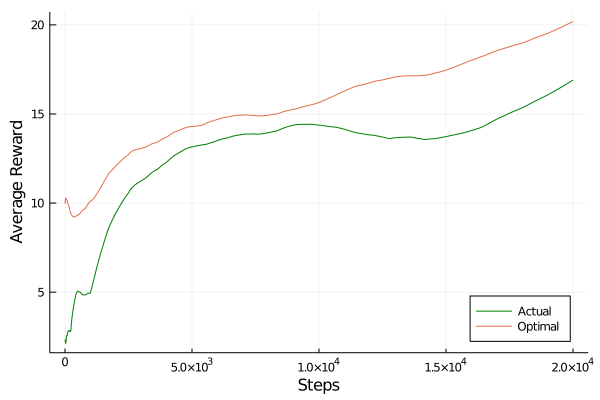

In [6]:
plot(1:steps, result₂["avg_reward_timeline"], leg=:bottomright, label="Actual", color=:green)
plot!(1:steps, result₂["avg_optimal_reward_timeline"], label="Optimal")
ylabel!("Average Reward")
xlabel!("Steps")

In this random seed, we can observe that the actual rewards appear to diverge from the optimal rewards. 

Lastly, we change the action-value method to an "exponential recency-weighted average" method. In other words, $\alpha$ will be held constant. It follows from simple algebra that at time $t$ the data from time $(t-i)$ is given weight $(1 - \alpha)^i$. If $0 < \alpha < 1$, then this means that more recent data is weighed more than less recent data. We expect this agent to perform better on the non-stationary problem. 

10-armed bandit, stationary reward problem.
Using sample-average step size parameter.
Performing 20000 steps of the 0.01-greedy algorithm...

Actions taken: [259, 21, 21, 20, 14, 22, 5123, 8260, 16, 6244]
Total rewards:   393921.1644822106
Optimal rewards: 403820.4371486234
Error: -9899.272666412813


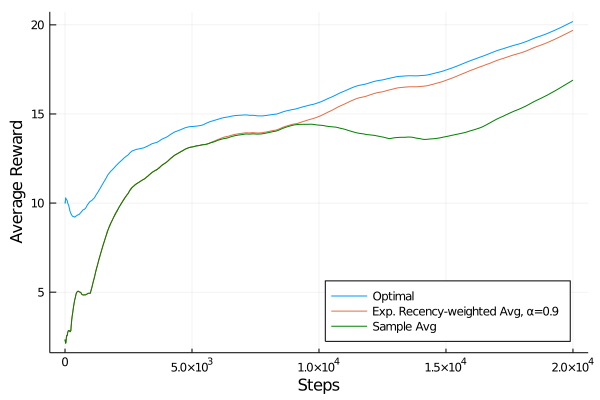

In [7]:
Random.seed!(42)

moving_mean_rewards = copy(stationary_mean_rewards)

α₂ = n -> 0.9

result₃ = ϵ_greedy_k_armed_bandit(ϵ, k, α₂, moving_bandit, steps)

println(k, "-armed bandit, stationary reward problem.")
println("Using sample-average step size parameter.")
println("Performing ", steps, " steps of the ", ϵ, "-greedy algorithm...\n")
println("Actions taken: ", result₃["N"])
println("Total rewards:   ", result₃["total_rewards"])
println("Optimal rewards: ", result₃["optimal_rewards"])
println("Error: ", result₃["total_rewards"] - result₃["optimal_rewards"])

plot(1:steps, result₃["avg_optimal_reward_timeline"], leg=:bottomright, label="Optimal")
plot!(1:steps, result₃["avg_reward_timeline"], label="Exp. Recency-weighted Avg, α=0.9")
plot!(1:steps, result₂["avg_reward_timeline"], label="Sample Avg", color=:green)
ylabel!("Average Reward")
xlabel!("Steps")

Now we observe that the actual reward follows the optimal reward fairly closely. It is interesting to see that, for this choice of $\alpha_2$, the two different methods are almost exactly the same until they diverge at $1.0 \times 10^4$ steps. Note that this doesn't happen for every choice of $\alpha_2$, but here it was chosen via trial an error. It seems like different choices of constant to use for $\alpha_2$ can lead to drastically different results. 

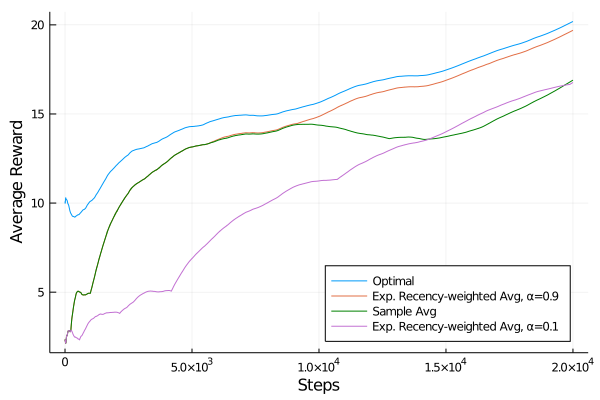

In [8]:
Random.seed!(42)

moving_mean_rewards = copy(stationary_mean_rewards)

α₃ = n -> 0.1

result₄ = ϵ_greedy_k_armed_bandit(ϵ, k, α₃, moving_bandit, steps)

plot(1:steps, result₃["avg_optimal_reward_timeline"], leg=:bottomright, label="Optimal")
plot!(1:steps, result₃["avg_reward_timeline"], label="Exp. Recency-weighted Avg, α=0.9")
plot!(1:steps, result₂["avg_reward_timeline"], label="Sample Avg", color=:green)
plot!(1:steps, result₄["avg_reward_timeline"], label="Exp. Recency-weighted Avg, α=0.1")
ylabel!("Average Reward")
xlabel!("Steps")

Let's throw a greedy (i.e. $\epsilon = 0$) plot up just to compare.

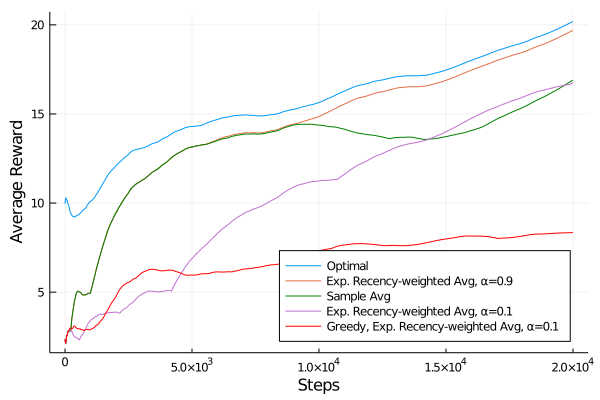

In [9]:
Random.seed!(42)

moving_mean_rewards = copy(stationary_mean_rewards)

ϵ = 0.0

result₅ = ϵ_greedy_k_armed_bandit(ϵ, k, α₃, moving_bandit, steps)

plot(1:steps, result₃["avg_optimal_reward_timeline"], leg=:bottomright, label="Optimal")
plot!(1:steps, result₃["avg_reward_timeline"], label="Exp. Recency-weighted Avg, α=0.9")
plot!(1:steps, result₂["avg_reward_timeline"], label="Sample Avg", color=:green)
plot!(1:steps, result₄["avg_reward_timeline"], label="Exp. Recency-weighted Avg, α=0.1")
plot!(1:steps, result₅["avg_reward_timeline"], label="Greedy, Exp. Recency-weighted Avg, α=0.1", color=:red)
ylabel!("Average Reward")
xlabel!("Steps")